This notebook coves the topic of identifying which celebrities JUUL targeted to promote their vaping product.

For researchers who would prefer to work with optical character recognition (OCR) text for JUUL vs State of North Carolina case from within their own database systems, these files are available for free download via the link below.
https://ucsf.app.box.com/v/IDL-DataSets/file/1447029625798

Note: The link provides access to the most current dataset, as the website undergoes a new release each month. Ensure that you have sufficient storage available to download the zip file with the OCR text (7-9 GB).


#### Step 1: Retrieve documents ids relevant to the query using the API wrapper

Import the required libraries

In [1]:
import re
import polars as pl
from src.api.ucsf_api import IndustryDocsSearch

Code to retrieve document ids which will then be used to retrieve OCR text

In [ ]:
query = '(collection:"JUUL labs Collection" AND case:"State of North Carolina" AND "celebrity" AND type:"Email")' # modify as required
api = IndustryDocsSearch()
api.query(q=query, ocr=True)

api.save('collected_documents.parquet')


Sanity check: The documents are updated periodically and hence the ocr text for all ids may not be available in the zip file. Run the code cell below to check the document ids for which OCR text was not extracted from the zip file.

In [2]:
df = pl.read_parquet('collected_documents.parquet')
no_ocr_ids = df.filter(pl.col('ocr_content').is_null())['id']
print(f"OCR text was not extracted for the following IDs: {no_ocr_ids}")


OCR text was not extracted for the following IDs: shape: (0,)
Series: 'id' [str]
[
]


Example of output for missing_ids

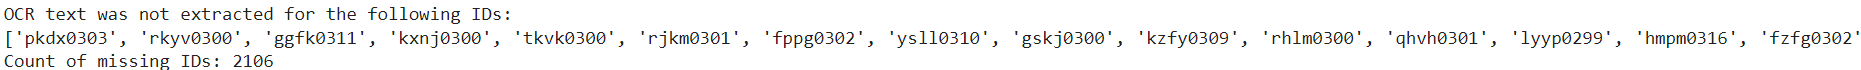


#### Named Entity Recognition (NER) is a method that identifies and classifies key information within the text into predefined categories such as names of people, organizations, locations, dates, and other entities.

#### For instance, NER can be used to identify key celebrities and organizations within the legal documents. This can be achieved using BERT (Bidirectional Encoder Representations from Transformers) which is a model designed to help machines understand human language more effectively. It's based on a type of neural network architecture called a transformer, which is particularly good at processing sequences of data, like sentences.

#### Transformer-based models can be fine-tuned for specific tasks by training them on specialized datasets. The model's ability to recognize different categories, such as sentiment, named entities, or topics, depends on what data it was trained on.



Run the code cell below to perform name entity recognition analysis directly using the OCR text (email). The output is seperated by each individual tag for ease of analysis

In [3]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from itertools import tee, islice

# Initialize the BERT NER model and tokenizer
model_name = "dslim/bert-large-NER"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Initialize the pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Function to extract text between "Subject:"/"Re:" and "CONFIDENTIAL".
# This function searches for text between "Subject:" or "Re:" and "CONFIDENTIAL" within a given text to extract content from the email body.

def extract_relevant_text(text):
    match = re.search(r'Subject:.*?CONFIDENTIAL|Re:.*?CONFIDENTIAL', text, re.DOTALL)
    if match:
        relevant_text = match.group(0)
        # Remove 'CONFIDENTIAL' and the leading part up to "Subject:" or "Re:"
        relevant_text = re.sub(r'(Subject:|Re:)', '', relevant_text)
        relevant_text = relevant_text.replace('CONFIDENTIAL', '').strip()
        return relevant_text
    return ""

# Function to extract NER tags
def extract_ner_tags(text):
    ner_results = ner_pipeline(text)
    return ner_results

# Function to get unigrams and bigrams from a list of words
def get_unigrams_and_bigrams(words):
    unigrams = words
    bigrams = [' '.join(bigram) for bigram in zip(words, islice(words, 1, None))]
    return unigrams + bigrams

# Process each OCR text and extract NER tags
ner_data = []
for row in df.head(10).iter_rows():
    doc_id = row[df.columns.index('id')]
    text = extract_relevant_text(str(row[df.columns.index('ocr_content')]))
    if text:
        ner_results = extract_ner_tags(text)
        for result in ner_results:
            word = result['word']
            # Check if 'entity_group' is present, otherwise use 'entity'
            entity = result.get('entity_group', result.get('entity'))
            ner_data.append({'id': doc_id, 'word': word, 'tag': entity})

# Convert the results to a DataFrame
ner_df = pl.DataFrame(ner_data)

# Create separate DataFrames for each tag category
categories = ner_df['tag'].unique()
for category in categories:
    category_df = ner_df.filter(pl.col("tag").eq(category))

    # For PERSON tags, ensure unigrams and bigrams to capture more meaningful names
    if category == 'B-PER':
        # Group words by document ID to form bigrams within the same document
        category_df_grouped = category_df.group_by('id')['word']
        expanded_data = []
        category_df_grouped_cols = category_df_grouped.columns
        for row in category_df_grouped.iter_rows():
            doc_id = row[category_df_grouped_cols.index('id')]
            words = row[category_df_grouped_cols.index('word')]
            unigrams_and_bigrams = get_unigrams_and_bigrams(words)
            for token in unigrams_and_bigrams:
                expanded_data.append({'id': doc_id, 'word': token, 'tag': 'B-PER'})
        category_df = pl.DataFrame(expanded_data)

    # Save each category to a separate parquet file
    output_path = f'ner_output_{category}.parquet'
    category_df.write_parquet(output_path)

/Users/trippwhaley/Library/Caches/pypoetry/virtualenvs/juul-document-analysis-cEBfJikH-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at dslim/bert-large-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware 

#### The output may require some manual oversight. Here's an example of what the output looks like

Run the code cell below to remove duplicates in the word column for the person file. This is useful in cases where you you want a more concise list of words.

In [4]:
# Remove duplicates in ner_output_PER based on word column
# Load the parquet file
for category in categories:
    df = pl.read_parquet(f'ner_output_{category}.parquet')

    # Remove duplicates based on the 'word' column
    df_cleaned = df.unique(pl.col('word'))
    print(df_cleaned.shape)

    # Save the de-duplicated DataFrame to a new Parquet file
    df_cleaned.write_parquet(f'ner_output_{category}_cleaned.parquet',)

(36, 3)
(10, 3)
(18, 3)
(61, 3)


Similarly, the following model can be used to extract keywords from the OCR text

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# Load the parquet file
df = pl.read_parquet('collected_documents.parquet')

# Initialize the keyword extraction model and tokenizer
model_name = "transformer3/H2-keywordextractor"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Create a pipeline for keyword extraction
keyword_extraction_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Function to extract text between "Subject:"/"Re:" and "CONFIDENTIAL".
# This function searches for text between "Subject:" or "Re:" and "CONFIDENTIAL" within a given text to extract content from the email body.
def extract_relevant_text(text):
    match = re.search(r'(Subject:|Re:).*?(CONFIDENTIAL|$)', text, re.DOTALL)
    if match:
        relevant_text = match.group(0)
        # Remove 'CONFIDENTIAL' and the leading part up to "Subject:" or "Re:"
        relevant_text = re.sub(r'(Subject:|Re:)', '', relevant_text)
        relevant_text = relevant_text.replace('CONFIDENTIAL', '').strip()
        return relevant_text
    return ""

# Function to extract keywords
def extract_keywords(text):
    keyword_results = keyword_extraction_pipeline(text)
    return keyword_results

# Process each OCR text and extract keywords
keyword_data = []
for row in df.iter_rows():
    doc_id = row[df.columns.index('id')]
    text = extract_relevant_text(str(row[df.columns.index('ocr_content')]))
    if text:
        try:
            keyword_results = extract_keywords(text)
            for result in keyword_results:
                keywords = result['generated_text'].split(", ")
                for keyword in keywords:
                    keyword_data.append({'id': doc_id, 'keyword': keyword})
        except Exception:
            pass

# Convert the results to a DataFrame
keyword_df = pl.DataFrame(keyword_data)
print(keyword_df)
# Save the results to a new Parquet file
output_path = 'keyword_output.parquet'
keyword_df.write_parquet(output_path)